# Wake Geometry of a Helicopter


In [87]:
# importing libraries
import os
import numpy
from scipy import integrate, linalg
from matplotlib import pyplot
from IPython.display import Image, display
%matplotlib inline

In [88]:
picture=Image(filename='picture.png')
figure=Image(filename='figure.png')

# Abstract

The wake geomerty of a helicopter is a complex unsteady three dimensional problem. By using the spatial iteration and
vortex control function, we assume the vortex consists of a series of straight-line elements. After iteration, we can finally get the the free wake model of the rotor. This model contains vortex intensity dissipation and the the infulence of the radius of vortex core. By using the Blade Element Theory(BET), the rotor can be seperated into many two-dimensional small sections along the wingspan. We can use the 2-d section to compute the feature of the fluid around the rotor.

Let's get started!

# Introduction

### 1.1 Model building
To simplify the model of the helicopter, we can assume there is only one blade rotating, so we can easily get the vortex strength (gamma) by using the Panel Method.
The speed of the helicopter is v_inf, (which means freestream speed is v_inf). As we just analyse the hovering codition, the v_inf is 0. The angle (alpha_s) between the v_inf and the rotating plane is called Rotor structure angle of attack. The rotor flow ratio (lamda) can be expressed as function 1.


### 1.2 Lift line theory
This theory assumes that the velocity and other parameter along the wing span changes much smaller than along the other two directions, so we can consider each 2-D blade section as a independence problem. This theory simplify the 3-D problem as a 2-D problem.


### 1.3 Shaft Frame
Set the rotor hub center as the origin, Z axis along the hub axis, pointing to the top. X axis is located in the structural plane of the rotor and it points to the tail of the helicopter. Y axis is determined by the right hand system. The y-z coordinate system represent the section of the rotor.


### 1.4 Vortex control equation
In the free wake model, the vortex movement can be described by the vortex control equation, which can be described as function (2). In this function, ψ (psi) is the Paddle azimuth; ζ (zeta) is wake life angle; v_loc is the local speed. Expand ψ and ζ and let dψ=dζ, we can finally get the function (3). V_ind is the sum of the vorticity caused by the vortices in the whole flow field to this node.


### 1.5 The discrete vortex function 
In order to get the numerical solution, the vortex control equation should be discrete. choose the ∆ψ and ∆ζ as one step in there respective direction. Then divide the control equation into five points, just as function (4) and (5). Combine with function (3) and let ∆ψ = ∆ζ, we can finally get function (6).


### 1.6 The initial condition and the periodic boundary conditions.
The rotor vortex is pulled out of the trailing edge of each blade so that the trailing edge of the blade is the trailing edge of the trailing vortex. Set the coordinates of a trailing edge node in the paddle coordinate system are (rv, 0, 0). We can finally get the initial vortex lines as the function (7). The periodic boundary conditions can be expressed as function (8). The illustration of the computation of free wake can be shown as figure (1).


### 1.7 The induced velocity of the vortex
By separating the computational space, the nodes on the free wake divide the trailing vortex into a series of straight vortex lines. The induced velocity on each vortex node is computed by the sum of all the vortex lines influence at this point. From the law of Biot-Savart, we can get the function (9). Figure (2) shows the method to get the induced velocity. In this figure, AB represent one small vortex line, P represent the spacial point we need to calculate the induced velocity.


### 1.8 Radius of vortex core model
In order to accurately simulate the vorticity of the vortex, radius of vortex core should be considered to eliminate the singularity at the fluid field. We can get a corrected induced velocity as function (10). In the function, rc is the radius of the vortex core 


### 1.9 The strength of the vortex 
By using the Panel Method, we can the blade attaching vortex, but it is difficult to get the tip whirls. A experience method could be used to estimate the tip whirls, which can be showed in function (11)


### 1.10 Dissipative effect processing
In the wake of the rotor, the vortex will gradually dissipate with the increase of the trailing life angle (ζ), so the intensity of the vortex will decrease and the vortex core radius will gradually increase.


### 1.11 The iteration of the free wake 
The method of the iteration is to get the new trail geometry by computing the induced velocity on the wake of the last step of the trailing position. Under the new wake, the new vortex strength is obtained according to the boundary condition of the blade leaf control point. The new induced velocity field is finally obtained by the convergence of wake and ring. The method can be expressed as function (12)

### 1.12 The initial free wake model
The initial wake structure in the free wake iteration is usually given by a fixed wake model, such as function (13)


### 1.13 Free wake convergence condition
When the mean square error of each trailing node in the whole calculation space is less than a certain threshold, the wake structure can be considered as convergent.
Function (14) shows this condition.


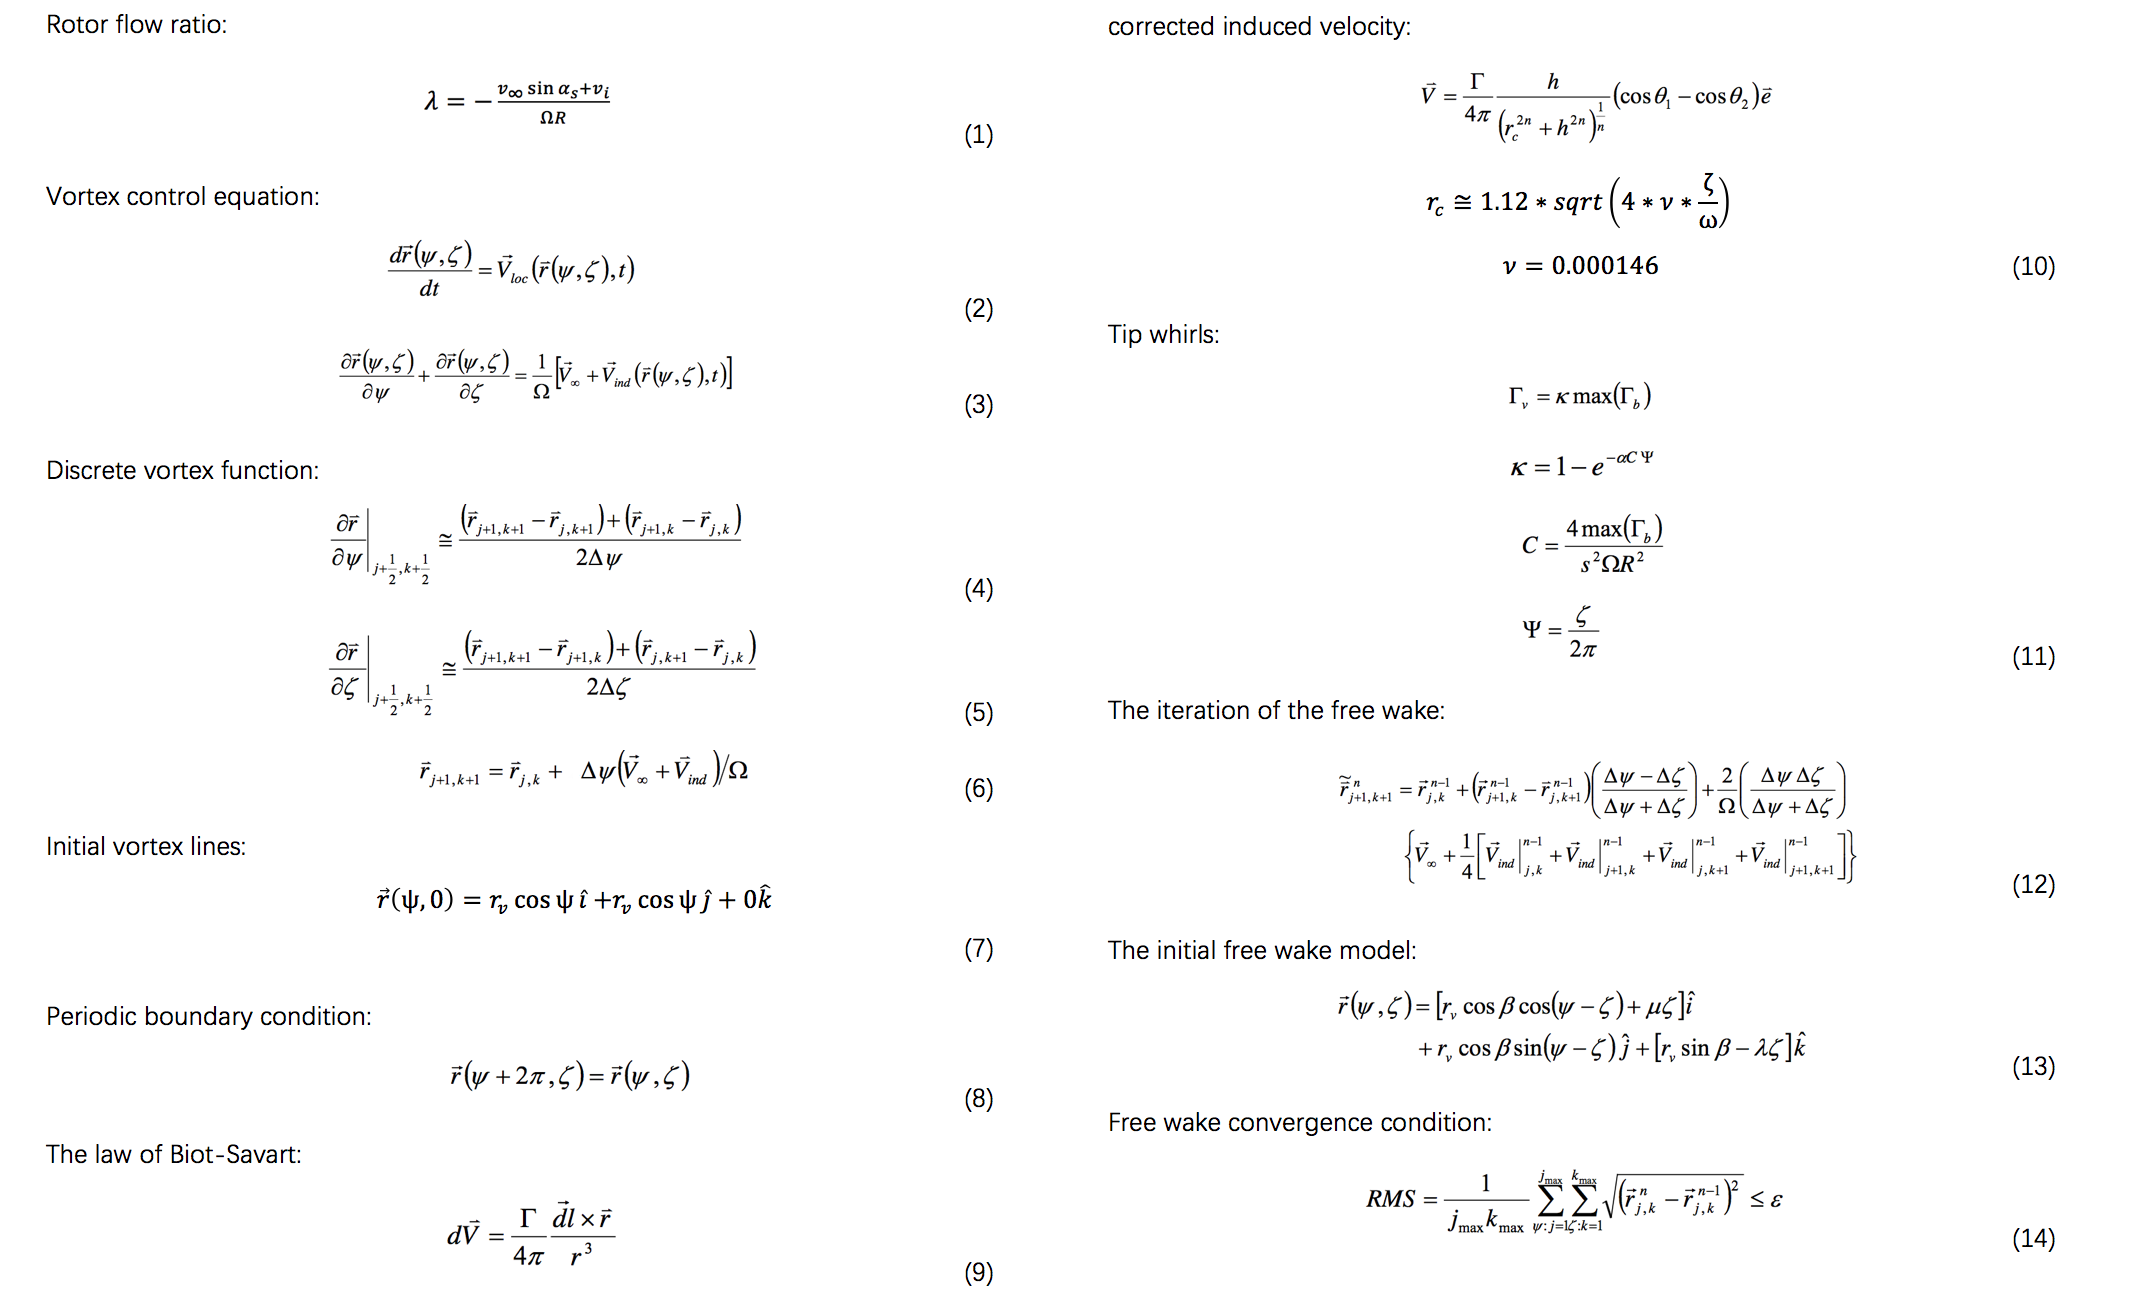

In [89]:
picture

The ideal wake geometries of a helicopter rotor in hovering and forward flight can be shown in figure 3. In this project I focused on the hovering condition.

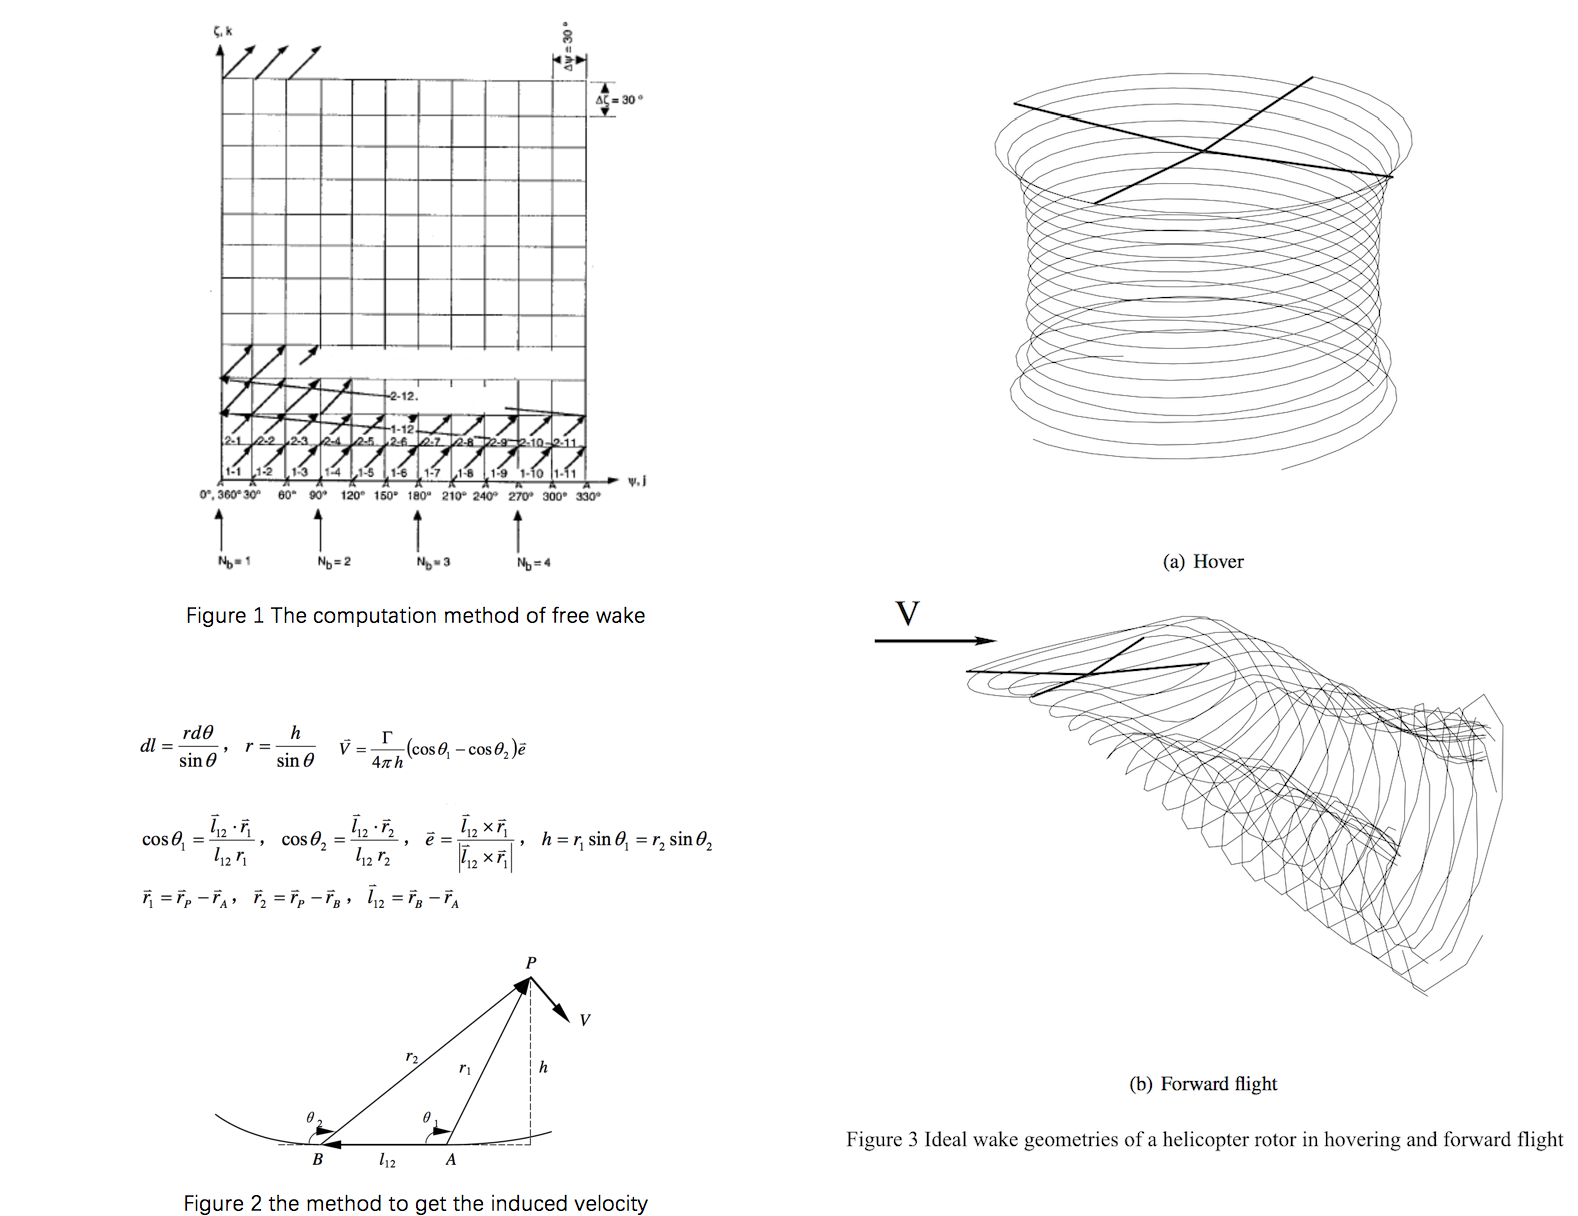

In [90]:
figure

## Initial vortex strength
By using the panel mehod learned in class, we can get a initial vortex strength (gamma) 

In [57]:
# defining class Panel with info on one panel
class Panel:
    def __init__(self, xa, ya, xb, yb):
        self.xa, self.ya = xa, ya 
        self.xb, self.yb = xb, yb 
        self.xc, self.yc = (xa+xb)/2, (ya+yb)/2         
        self.length = numpy.sqrt((xb-xa)**2+(yb-ya)**2) 
        if xb-xa <= 0.0:
            self.beta = numpy.arccos((yb-ya)/self.length)
        elif xb-xa > 0.0:
            self.beta = numpy.pi + numpy.arccos(-(yb-ya)/self.length)
        if self.beta <= numpy.pi:
            self.loc = 'upper' # upper surface
        else:
            self.loc = 'lower' # lower surface
        self.sigma = 0.0 
        self.vt = 0.0    
        self.cp = 0.0    
        
def define_panels(x, y, N):
    panels = numpy.empty(N, dtype=object)
    for i in range(N):
        panels[i] = Panel(x[i], y[i], x[i+1], y[i+1])
    return panels

class Freestream:
    def __init__(self, u_inf, alpha):
        self.u_inf = u_inf
        self.alpha = alpha*numpy.pi/180.0 # degrees to radians
        
def integral(x, y, panel, dxdk, dydk):
    def integrand(s):
        return ( ((x - (panel.xa - numpy.sin(panel.beta)*s))*dxdk
                  +(y - (panel.ya + numpy.cos(panel.beta)*s))*dydk)
                / ((x - (panel.xa - numpy.sin(panel.beta)*s))**2
                   +(y - (panel.ya + numpy.cos(panel.beta)*s))**2) )
    return integrate.quad(integrand, 0.0, panel.length)[0]

def source_contribution_normal(panels):
    A = numpy.empty((panels.size, panels.size), dtype=float)
    # source contribution on a panel from itself
    numpy.fill_diagonal(A, 0.5)
    # source contribution on a panel from others
    for i, panel_i in enumerate(panels):
        for j, panel_j in enumerate(panels):
            if i != j:
                A[i, j] = 0.5/numpy.pi*integral(panel_i.xc, panel_i.yc, panel_j,numpy.cos(panel_i.beta),numpy.sin(panel_i.beta))
    return A

def vortex_contribution_normal(panels):
    A = numpy.empty((panels.size, panels.size), dtype=float)
    # vortex contribution on a panel from itself
    numpy.fill_diagonal(A, 0.0)
    # vortex contribution on a panel from others
    for i, panel_i in enumerate(panels):
        for j, panel_j in enumerate(panels):
            if i != j:
                A[i, j] = -0.5/numpy.pi*integral(panel_i.xc, panel_i.yc, panel_j,numpy.sin(panel_i.beta),-numpy.cos(panel_i.beta))
    return A

def kutta_condition(A_source, B_vortex):

    b = numpy.empty(A_source.shape[0]+1, dtype=float)
    b[:-1] = B_vortex[0, :] + B_vortex[-1, :]
    b[-1] = - numpy.sum(A_source[0, :] + A_source[-1, :])
    return b

def build_singularity_matrix(A_source, B_vortex):
    A = numpy.empty((A_source.shape[0]+1, A_source.shape[1]+1), dtype=float)
    # source contribution matrix
    A[:-1, :-1] = A_source
    # vortex contribution array
    A[:-1, -1] = numpy.sum(B_vortex, axis=1)
    # Kutta condition array
    A[-1, :] = kutta_condition(A_source, B_vortex)
    return A

def build_freestream_rhs(panels, freestream):
    b = numpy.empty(panels.size+1,dtype=float)
    # freestream contribution on each panel
    for i, panel in enumerate(panels):
        b[i] = -freestream.u_inf * numpy.cos(freestream.alpha - panel.beta)
    # freestream contribution on the Kutta condition
    b[-1] = -freestream.u_inf*( numpy.sin(freestream.alpha-panels[0].beta)
                               +numpy.sin(freestream.alpha-panels[-1].beta) )
    return b

def compute_tangential_velocity(panels, freestream, gamma, A_source, B_vortex):
    A = numpy.empty((panels.size, panels.size+1), dtype=float)
    A[:, :-1] = B_vortex
    A[:, -1] = -numpy.sum(A_source, axis=1)
    b = freestream.u_inf*numpy.sin([freestream.alpha-panel.beta 
                                    for panel in panels])
    strengths = numpy.append([panel.sigma for panel in panels], gamma)
    tangential_velocities = numpy.dot(A, strengths) + b
    for i, panel in enumerate(panels):
        panel.vt = tangential_velocities[i]
        
def compute_pressure_coefficient(panels, freestream):
    for panel in panels:
        panel.cp = 1.0 - (panel.vt/freestream.u_inf)**2

In [65]:
x,y=numpy.loadtxt("naca0012.dat",dtype=float,unpack=True)
N_m,alpha=len(x)-1,0
R=3 #wing span(m)
omiga=5*2*numpy.pi  # angular velocity
u_inf=omiga*R/2 #assume the free stream velocity near the rotor is the linear velocity at the vortex point
freestream = Freestream(u_inf,alpha)
panels = define_panels(x,y,N_m)
A_source = source_contribution_normal(panels)
B_vortex = vortex_contribution_normal(panels)
A = build_singularity_matrix(A_source, B_vortex)
b = build_freestream_rhs(panels, freestream)
strengths = numpy.linalg.solve(A, b)
for i , panel in enumerate(panels):
    panel.sigma = strengths[i]
gamma_air = strengths[-1]
compute_tangential_velocity(panels, freestream, gamma_air, A_source, B_vortex)

In [64]:
# Due to the lift line theory, the strength of vortex gamma(r) is a function along the wingspan r. we assume
# the strength of attaching vortex is a constant computed by the Panel Method. 
gamma=gamma_air/2 
gamma

0.69439587508062428

## The initial wake structure

In [26]:
def Vortex_point_initial(rv,psi,zeta,beta,miu,lamda):
    x=rv*numpy.cos(beta)*numpy.cos(psi-zeta)+miu*zeta
    y=rv*numpy.cos(beta)*numpy.sin(psi-zeta)
    z=rv*numpy.sin(beta)-lamda*zeta
    r=numpy.array([x,y,z])
    return r

In [72]:
N=12 # divided 2*pi into 12 parts, each part is 30 degree
N_j=N*1 # As the psi has boundary condition, we just need one circle(2*Pi) to compute 
N_k=N*4 # the number of wake age angle.
R=50 #wing span(m)
omiga=5*2*numpy.pi  # angular velocity of the rotor
rv=1  #the posion of the vortex in the x-axis direction at the begining time
d_psi=numpy.pi*2/N
d_zeta=numpy.pi*2/N # set delta psi and delta zeta is equal. It can simplify the function
psi=[[0 for j in range(N_j)]  for k in range(N_k+1)] 
lamda=0.05  # rotor inflow ratio, we can assume it is constant as we assume the inflow is uniform inflow 
zeta=[[0 for j in range(N_j)]  for k in range(N_k+1)] 
miu=[[0 for j in range(N_j)]  for k in range(N_k+1)] 
beta=[[0 for j in range(N_j)]  for k in range(N_k+1)] 
## beta=miu=0 because we assume helicopter is hovering

# the mesh of zeta and psi just like figure 1
for k in range(N_k+1):
    for j in range(N_j):
        psi[k][j]=j*d_psi

for k in range(N_k+1):
    for j in range(N_j):
        zeta[k][j]=k*d_psi

In [76]:
# this is the initial wake structure
vortex_points= [[0 for j in range(N_j)]  for k in range(N_k+1)]
for k in range(N_k+1):
    for j in range(N_j):
        vortex_points[k][j]=Vortex_point_initial(rv,psi[k][j],zeta[k][j],beta[k][j],miu[k][j],lamda)

### The code of induced velocity
From figure 2,we can get how to copute the induced velocity

In [77]:
def induced_velocity(point,vortex_points,gamma,zeta_i,omiga,n,N_k,N_j,i,R):
    v_induced=numpy.array([0,0,0])
    c=4*gamma/omiga/(R**2)
    #calculate induced velocity at point(j,k)
    for a in range (N_k):
        for b in range (N_j):
            k=1-numpy.e**(-7000*c*zeta[a][b]/numpy.pi/2) 
# as I only assume the max zeta is 6*pi. it will cost too much time to compute if I increase the maximum of zeta. 
# In order to simulate validity of the rotor tip whirls, I have to increase the parameter of 
# alpha(Forced roll coefficient) to the value of 7000. The alpha is smaller in real condition.
            gamma_i=k*gamma # gamma_i is the strength of tip vortex, gamma is the attaching vortex strength
            r1=point-vortex_points[a][b] # vector from  p(a,b) to p
            r2=point-vortex_points[a+1][b] # vector from  p(a,b+1) to p
            r1_value=numpy.sqrt(r1[0]**2+r1[1]**2+r1[2]**2) # the length from the point to the beginning point of the vortex line
            r2_value=numpy.sqrt(r2[0]**2+r2[1]**2+r2[2]**2) # the length from the point to the end point of the vortex line
            judge=r1_value*r2_value
            if judge!=0:  # this means the value of r1 and r2 are not zero
                l=vortex_points[a+1][b]-vortex_points[a][b]  # one vortex line
                l_value=numpy.sqrt(l[0]**2+l[1]**2+l[2]**2)
                theta1=numpy.arccos(numpy.dot(l,r1)/l_value/r1_value)
                theta2=numpy.arccos(numpy.dot(l,r2)/l_value/r2_value)
                h=r1_value*numpy.sin(theta1)
                cross=numpy.cross(l,r1)
                e=cross/numpy.sqrt(cross[0]**2+cross[1]**2+cross[2]**2)
                rc=1.12*numpy.sqrt(4*(0.1*gamma_i+0.000146)*zeta_i/omiga) #to compute the radius of vortex core 
                v=gamma_i/4/numpy.pi*h/((rc**(2*n)+h**(2*n))**(1/n))*(numpy.cos(theta1)-numpy.cos(theta2))*e
                v_induced=v_induced+v
            elif judge==0:  # this means the point is close to vortex core, which means it is a singularity. 
                            # we can assume the the induced velocity is 0 when we compute the influnce of this vortex line to the point 
                v_induced=v_induced
    return v_induced
    

### The code of interration
The induced velocity of a certain point is approximated by the mean of the induced velocity of 4 points around it. the relation between the new vortex point and the old is given by the function (12)

In [30]:
def vortex_points_iteration(vortex_points,gamma,zeta,omiga,d_psi,n,N_k,N_j,R):
    vortex_new=numpy.empty_like(vortex_points)
    for k in range (N_k):
        for j in range(N_j): 
            vortex_new[k][j]=vortex_points[k][j]
    for k in range (N_k):
        for j in range(N_j):
            a=k;b=j;c=k+1;d=j+1;
            if j==11:
                d=0 # periodic boundary condition
            i=k
            zeta_i=zeta[i][0]  # set the zeta_i
            point1=vortex_points[a][b]
            point2=vortex_points[c][b]
            point3=vortex_points[a][d]
            point4=vortex_points[c][d]
            v1=induced_velocity(point1,vortex_points,gamma,zeta_i,omiga,n,N_k,N_j,i,R)
            v2=induced_velocity(point2,vortex_points,gamma,zeta_i,omiga,n,N_k,N_j,i,R)
            v3=induced_velocity(point3,vortex_points,gamma,zeta_i,omiga,n,N_k,N_j,i,R)
            v4=induced_velocity(point4,vortex_points,gamma,zeta_i,omiga,n,N_k,N_j,i,R)
            v=(v1+v2+v3+v4)/4
            if j<11:
                vortex_new[k+1][j+1]=vortex_points[k][j]+v/omiga*d_psi
            elif j==11:
                vortex_new[k+1][0]=vortex_points[k][j]+v/omiga*d_psi #periodic boundary condition
    return vortex_new

### Free wake convergence condition
Erro represents the difference between the new wake structure and the old after one interation, which is given by the function (14)


In [31]:
def wake_convergence_erro(n,N_k,N_j,vortex_points_1,vortex_points_2):
    erro=0
    for k in range(N_k):
        for j in range(N_j):
            deference=vortex_points_1[k][j]-vortex_points_2[k][j]
            erro=erro+numpy.sqrt(deference[0]**2+deference[1]**2+deference[2]**2)/N/N
    return erro


### Outcome
As it needs too much time to get a steady solution, I only iterate 51 times. However it will still take over one hours to compute the outcome.In other literature, the maximum of the zeta is more than 60 pi. I only set it as 8 pi,but it will still cost a lot of time to compute. After 51 times of iteration, the erro is 0.27, so it can be regarded as a steady solution. 

In [79]:
erro=0;m=51
# to shorter the computaion time, we can decrease m (the times of iteration) or decrease the maximum of zeta, 
# but this will decrease the accuracy.
n=1;
iteration=numpy.empty(100, dtype=object)
iteration[0]=vortex_points #initial wake structure
while m>0:
    iteration[n]=vortex_points_iteration(iteration[n-1],gamma,zeta,omiga,d_psi,n,N_k,N_j,R)
    # this reperent a set of n itertion 
    erro=wake_convergence_erro(n,N_k,N_j,iteration[n-1],iteration[n])
    m=m-1
    n=n+1

In [80]:
# after 51st times of iteration, the Free wake convergence condition is showned as follow:
erro

0.26987093258298217

### The initial wake structure
As there is only one roter, we can take points from the mesh when the psi is 0，then we can get a wake structure

In [81]:
# the initial free wake
c=0
x=[];y=[];z=[];
for k in range (N_k):
    x=numpy.append(x,iteration[c][k][0][0])
    y=numpy.append(y,iteration[c][k][0][1])
    z=numpy.append(z,iteration[c][k][0][2])

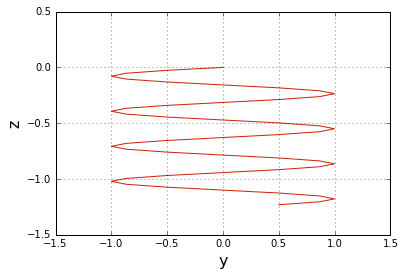

In [82]:
# in the y-z plane
width = 6
pyplot.figure(figsize=(width, width))
pyplot.grid()
pyplot.xlabel('y', fontsize=16)
pyplot.ylabel('z', fontsize=16)
pyplot.plot(y,z,color='#CD2305')
pyplot.axis('scaled', adjustable='box')
pyplot.xlim(-1.5, 1.5)
pyplot.ylim(-1.5, 0.5);

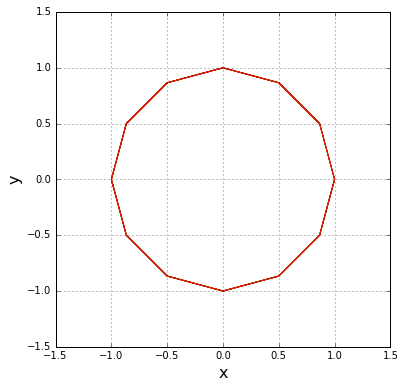

In [83]:
# in the x-y plane
width = 6
pyplot.figure(figsize=(width, width))
pyplot.grid()
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
pyplot.plot(x,y,color='#CD2305')
pyplot.axis('scaled', adjustable='box')
pyplot.xlim(-1.5, 1.5)
pyplot.ylim(-1.5, 1.5);

### Wake geometry after 51st times of iteration

In [84]:
# 51st times of iteration
c=51
x=[];y=[];z=[];
for k in range (N_k):
    x=numpy.append(x,iteration[c][k][0][0])
    y=numpy.append(y,iteration[c][k][0][1])
    z=numpy.append(z,iteration[c][k][0][2])

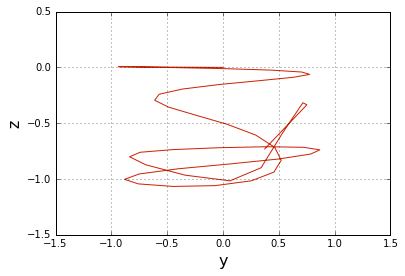

In [85]:
# in the y-x plane
width = 6
pyplot.figure(figsize=(width, width))
pyplot.grid()
pyplot.xlabel('y', fontsize=16)
pyplot.ylabel('z', fontsize=16)
pyplot.plot(y,z,color='#CD2305')
pyplot.axis('scaled', adjustable='box')
pyplot.xlim(-1.5, 1.5)
pyplot.ylim(-1.5, 0.5);

In this figure, I think the reason why the wake rebounce at the end is that the maximum of zeta is not big enough.   

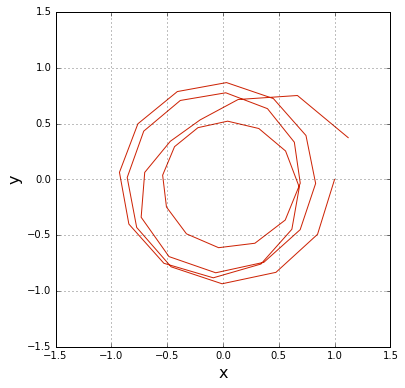

In [86]:
# in the x-y plane
width = 6
pyplot.figure(figsize=(width, width))
pyplot.grid()
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
pyplot.plot(x,y,color='#CD2305')
pyplot.axis('scaled', adjustable='box')
pyplot.xlim(-1.5, 1.5)
pyplot.ylim(-1.5, 1.5);

# Conclusion and Limitation
This project consideres different parameters and models to simulate the wake structure of the roter. After computation, we can get a real wake structure. It will be useful in the next steps if we try to analyze the fluid around the rotor.

Although I have tried my best in these two weeks, there is still much work could be done.

First of all, I consider the relationship between the tip vortex and the blade attaching vortex shown in function (11), but I just assume the attaching vortex is a constant computed by the panel method. During the iteration of the vortex lines, this strength of vortex should also be interated, but it will cost huge time to compute.

Secondly, I only consider the hovering condition of the helicopter, the forward flight is also signigicant to analyze.

Thirdly, After I get the vortex lines, I could get the velocity distribution and the pressure coefficient around the rotor, but I spend too much time on the basic theory of the rotor system.

Fourthly, some parameters in some models such as the vortex core and dissipative effect are too complex to compute, I have to regard them as approximate constant. This may cause some erro to the final wake structure. 

# Reference
[1] Quackenbush, T. R., Keller, J. D., Wachspress, D. A., et al, Reduced Order Free Wake
Modeling for Near Rear Time Simulation of Rotorcraft Flight Mechanics, Presented at the American Helicopter Society 55th Annual Forum, Montreal, QC, May 25-27 1999.

[2] Roura, M., Cuerva, A., Sanz-Andrés, A., & Barrero-Gil, A. (2010). A panel method free-wake code for aeroelastic rotor predictions. Wind Energy, 13(4), 357-371. doi:10.1002/we.358

[3] Seong Yong Wie, Seongkyu Lee, and Duck Joo Lee.  "Potential Panel and Time-Marching Free-Wake-Coupling Analysis for Helicopter Rotor", Journal of Aircraft, Vol. 46, No. 3 (2009), pp. 1030-1041. 
http://dx.doi.org/10.2514/1.40001

[4] Landgrebe, A. J., An Analytical Method for Predicting Rotor Wake Geometry,
Journal of the American Helicopter Society, Vol.14, (4), Oct 1969, pp.20-32.

[5] Bliss, D. B. and Miller, W. O., Efficient Free Wake Calculations Using Analytical/
Numerical Matching, Journal of the American Helicopter Society, Vol.38, (2), Apr
1993, pp.43-52.
